In [ ]:
import os
import json
from pathlib import Path
from dotenv import load_dotenv
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [ ]:
# Load paths from .env
load_dotenv()

DATASET_DIR = os.getenv('DATASET_CLEANED')         
ANNOTATION_JSON = os.getenv('ANNOTATION_CLEANED')
OUTPUT_DIR = os.getenv('OUTPUT_DIR')       
os.makedirs(OUTPUT_DIR, exist_ok=True)

TRAIN_JSON = os.path.join(OUTPUT_DIR, 'train_split.json')
VAL_JSON = os.path.join(OUTPUT_DIR, 'val_split.json')

VAL_SPLIT = 0.2
TRUST_THRESHOLD = 0.5


In [3]:
# Load annotations
with open(ANNOTATION_JSON, 'r') as f:
    annotations = json.load(f)
    
print(f"Loaded {len(annotations)} images from JSON.")


Loaded 8000 images from JSON.


In [ ]:
# Prepare multi-label matrix
all_parts = set()
for img_data in annotations.values():
    all_parts.update(img_data['parts'].keys())
all_parts = sorted(list(all_parts))

# Create multi-label array
img_ids = list(annotations.keys())
X = np.array(img_ids)  # dummy X (image IDs)
y = np.zeros((len(img_ids), len(all_parts)), dtype=int)

for i, img_id in enumerate(img_ids):
    for j, part_name in enumerate(all_parts):
        if part_name in annotations[img_id]['parts']:
            state = annotations[img_id]['parts'][part_name]['object_state_class']
            y[i, j] = state  


In [5]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=VAL_SPLIT, random_state=42)

for train_idx, val_idx in msss.split(X, y):
    train_ids = X[train_idx]
    val_ids = X[val_idx]

train_annotations = {k: annotations[k] for k in train_ids}
val_annotations = {k: annotations[k] for k in val_ids}

print(f"Train images: {len(train_annotations)}")
print(f"Validation images: {len(val_annotations)}")


Train images: 6418
Validation images: 1582


In [6]:
with open(TRAIN_JSON, 'w') as f:
    json.dump(train_annotations, f, indent=2)

with open(VAL_JSON, 'w') as f:
    json.dump(val_annotations, f, indent=2)

print(f"Saved train/validation splits in {OUTPUT_DIR}")


Saved train/validation splits in C:/Users/rimba/Desktop/AIM/cv/processed_data


In [7]:
# Check distribution for each part
def part_distribution(data):
    dist = {}
    for part in all_parts:
        counts = {}
        for img in data.values():
            if part in img['parts']:
                cls = img['parts'][part]['object_state_class']
                counts[cls] = counts.get(cls, 0) + 1
        dist[part] = counts
    return dist

print("Train distribution per part:")
print(part_distribution(train_annotations))
print("\nValidation distribution per part:")
print(part_distribution(val_annotations))


Train distribution per part:
{'back_hand_break': {2: 2257, 0: 3345, 3: 749, 1: 67}, 'back_handle': {2: 239, 0: 4752, 1: 126, 3: 1300}, 'back_light': {2: 2910, 1: 1273, 0: 1974, 3: 261}, 'back_mudguard': {1: 424, 3: 514, 0: 5212, 2: 268}, 'back_pedal': {3: 3375, 0: 2940, 1: 53, 2: 49}, 'back_reflector': {0: 4200, 3: 738, 2: 1350, 1: 130}, 'back_wheel': {1: 1198, 0: 4823, 3: 393, 2: 3}, 'bell': {2: 3087, 3: 1504, 0: 1590, 1: 230}, 'chain': {3: 4425, 0: 1671, 1: 235, 2: 86}, 'dress_guard': {2: 4774, 0: 975, 3: 320, 1: 349}, 'dynamo': {0: 2477, 2: 3304, 1: 148, 3: 488}, 'front_handbreak': {0: 3801, 2: 2229, 1: 78, 3: 304}, 'front_handle': {0: 5715, 1: 186, 2: 228, 3: 280}, 'front_light': {0: 3394, 2: 2265, 1: 565, 3: 193}, 'front_mudguard': {0: 5290, 1: 595, 2: 446, 3: 87}, 'front_pedal': {0: 6140, 1: 89, 2: 56, 3: 128}, 'front_wheel': {0: 5034, 1: 412, 3: 925, 2: 38}, 'gear_case': {0: 4124, 2: 1220, 3: 321, 1: 749}, 'kickstand': {0: 4048, 3: 1104, 2: 1105, 1: 161}, 'lock': {0: 4252, 2: 16

In [ ]:
load_dotenv()  

# Read paths
TRAIN_JSON = os.getenv("TRAIN_JSON")
VAL_JSON = os.getenv("VAL_JSON")

# Verify
print(f"Train JSON path: {TRAIN_JSON}")
print(f"Validation JSON path: {VAL_JSON}")

with open(TRAIN_JSON, 'r') as f:
    train_data = json.load(f)

with open(VAL_JSON, 'r') as f:
    val_data = json.load(f)

In [10]:
# Object state labels
state_labels = {0: "intact", 1: "damaged", 2: "absent", 3: "occluded"}

def overall_class_counts(data):
    counts = {k: 0 for k in state_labels.keys()}
    for img_data in data.values():
        for part in img_data['parts'].values():
            obj_state_class = part['object_state_class']
            counts[obj_state_class] += 1
    return counts

train_counts = overall_class_counts(train_data)
val_counts = overall_class_counts(val_data)

# Convert counts to percentages
def counts_to_pct(counts):
    total = sum(counts.values())
    return {state_labels[k]: v/total*100 for k,v in counts.items()}

train_pct = counts_to_pct(train_counts)
val_pct = counts_to_pct(val_counts)

print("Train percentages:", train_pct)
print("Validation percentages:", val_pct)


Train percentages: {'intact': 60.55691359336806, 'damaged': 6.178481595635384, 'absent': 19.61171927587062, 'occluded': 13.652885535125945}
Validation percentages: {'intact': 59.8947852584373, 'damaged': 6.0225378025642495, 'absent': 20.261024550106367, 'occluded': 13.821652388892083}


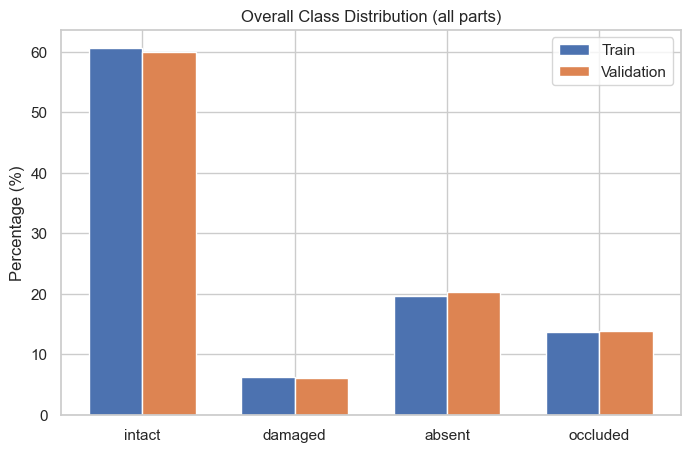

In [11]:
labels = list(train_pct.keys())
train_vals = [train_pct[l] for l in labels]
val_vals = [val_pct[l] for l in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width/2, train_vals, width, label="Train")
ax.bar(x + width/2, val_vals, width, label="Validation")

ax.set_ylabel("Percentage (%)")
ax.set_title("Overall Class Distribution (all parts)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [13]:
# Object state labels
state_labels = {0: "intact", 1: "damaged", 2: "absent", 3: "occluded"}

def part_class_percentages(data):
    """Return a dict: part -> {class_label: percentage}"""
    part_counts = {}
    
    for img_data in data.values():
        for part_name, part in img_data['parts'].items():
            cls = part['object_state_class']
            if part_name not in part_counts:
                part_counts[part_name] = {k: 0 for k in state_labels.keys()}
            part_counts[part_name][cls] += 1
    
    # Convert to percentages
    part_pct = {}
    for part, counts in part_counts.items():
        total = sum(counts.values())
        part_pct[part] = {state_labels[k]: counts[k]/total*100 for k in state_labels.keys()}
    
    return part_pct

train_part_pct = part_class_percentages(train_data)
val_part_pct = part_class_percentages(val_data)


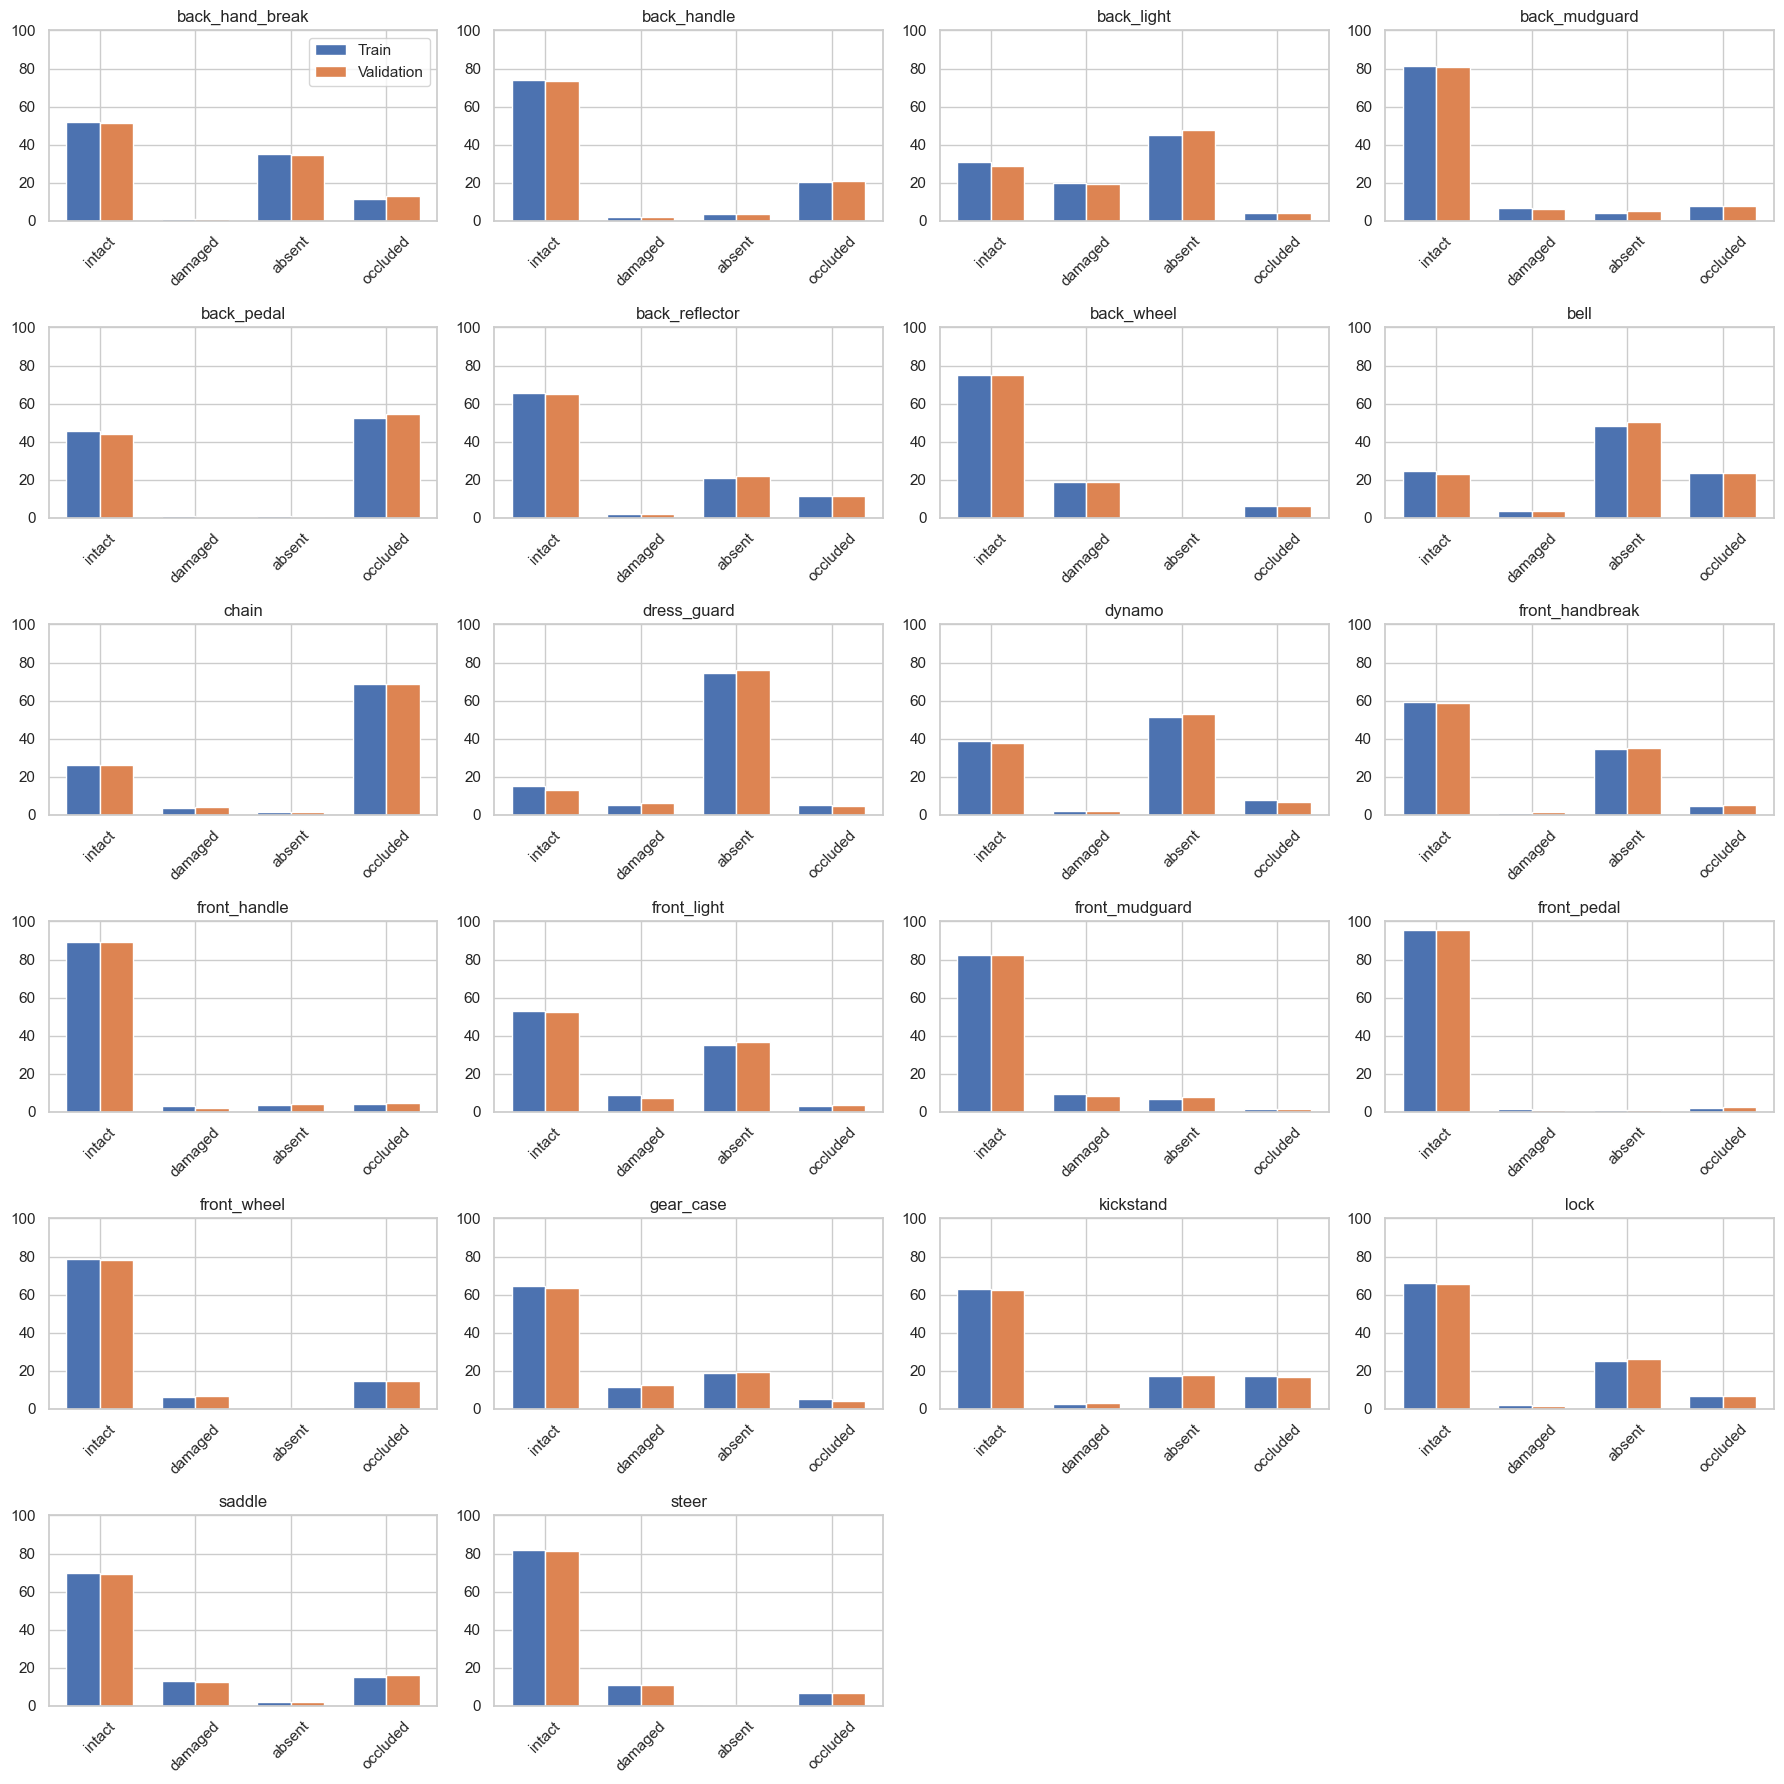

In [ ]:
parts = list(train_part_pct.keys())
num_parts = len(parts)
cols = 4 
rows = int(np.ceil(num_parts / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, rows*3))
axes = axes.flatten()

for i, part in enumerate(parts):
    labels = list(train_part_pct[part].keys())
    train_vals = [train_part_pct[part][l] for l in labels]
    val_vals = [val_part_pct.get(part, {l:0 for l in labels})[l] for l in labels]

    x = np.arange(len(labels))
    width = 0.35

    axes[i].bar(x - width/2, train_vals, width, label='Train')
    axes[i].bar(x + width/2, val_vals, width, label='Validation')
    axes[i].set_title(part)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels, rotation=45)
    axes[i].set_ylim(0, 100)
    if i == 0:
        axes[i].legend()

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


In [ ]:

load_dotenv()

# Paths
DATASET_CLEANED = Path(os.getenv("DATASET_CLEANED"))
TRAIN_JSON = Path(os.getenv("TRAIN_JSON"))
VAL_JSON = Path(os.getenv("VAL_JSON"))
TRAIN_CLEANED = Path(os.getenv("TRAIN_CLEANED"))
VAL_CLEANED = Path(os.getenv("VAL_CLEANED"))

# Make sure output folders exist
TRAIN_CLEANED.mkdir(parents=True, exist_ok=True)
VAL_CLEANED.mkdir(parents=True, exist_ok=True)

print(f"Dataset folder: {DATASET_CLEANED}")
print(f"Train JSON: {TRAIN_JSON}")
print(f"Val JSON: {VAL_JSON}")
print(f"Train folder: {TRAIN_CLEANED}")
print(f"Val folder: {VAL_CLEANED}")


Dataset folder: C:\Users\rimba\Desktop\AIM\cv\processed_data\train
Train JSON: C:\Users\rimba\Desktop\AIM\cv\processed_data\train_split.json
Val JSON: C:\Users\rimba\Desktop\AIM\cv\processed_data\val_split.json
Train folder: C:\Users\rimba\Desktop\AIM\cv\processed_data\train
Val folder: C:\Users\rimba\Desktop\AIM\cv\processed_data\val


In [23]:
# Load train/val JSON
with open(TRAIN_JSON, 'r') as f:
    train_data = json.load(f)

with open(VAL_JSON, 'r') as f:
    val_data = json.load(f)

print(f"Number of train images: {len(train_data)}")
print(f"Number of val images: {len(val_data)}")


Number of train images: 6418
Number of val images: 1582


In [24]:
def copy_images(image_keys, src_folder, dst_folder):
    copied = 0
    for img_name in image_keys:
        src_path = src_folder / img_name
        dst_path = dst_folder / img_name
        if not src_path.exists():
            print(f"⚠️ Missing image: {img_name}")
            continue
        if src_path.resolve() == dst_path.resolve():
            # Same file, skip
            continue
        shutil.copy(src_path, dst_path)
        copied += 1
    print(f"✅ Copied {copied}/{len(image_keys)} images to {dst_folder}")


In [ ]:
from pathlib import Path
import shutil

# Ensure src/dst are Path objects
DATASET_CLEANED = Path(DATASET_CLEANED)  
TRAIN_CLEANED = Path(TRAIN_CLEANED)      
VAL_CLEANED = Path(VAL_CLEANED)          

# Make sure destination folders exist
TRAIN_CLEANED.mkdir(parents=True, exist_ok=True)
VAL_CLEANED.mkdir(parents=True, exist_ok=True)

def copy_images(image_keys, src_folder, dst_folder):
    copied = 0
    for img_name in image_keys:
        src_path = src_folder / img_name
        dst_path = dst_folder / img_name
        if not src_path.exists():
            print(f"⚠️ Missing image: {img_name}")
            continue
        if src_path.resolve() == dst_path.resolve():
            # Same file, skip
            continue
        shutil.copy(src_path, dst_path)
        copied += 1
    print(f"✅ Copied {copied}/{len(image_keys)} images to {dst_folder}")

# Copy train and val images
copy_images(train_data.keys(), DATASET_CLEANED, TRAIN_CLEANED)
copy_images(val_data.keys(), DATASET_CLEANED, VAL_CLEANED)


⚠️ Missing image: 48678.jpg
⚠️ Missing image: 48691.jpg
⚠️ Missing image: 48695.jpg
⚠️ Missing image: 48697.jpg
⚠️ Missing image: 48701.jpg
⚠️ Missing image: 48712.jpg
⚠️ Missing image: 48716.jpg
⚠️ Missing image: 48718.jpg
⚠️ Missing image: 48719.jpg
⚠️ Missing image: 48720.jpg
⚠️ Missing image: 48721.jpg
⚠️ Missing image: 48724.jpg
⚠️ Missing image: 48725.jpg
⚠️ Missing image: 48729.jpg
⚠️ Missing image: 48730.jpg
⚠️ Missing image: 48731.jpg
⚠️ Missing image: 48732.jpg
⚠️ Missing image: 48733.jpg
⚠️ Missing image: 48735.jpg
⚠️ Missing image: 48736.jpg
⚠️ Missing image: 48737.jpg
⚠️ Missing image: 48738.jpg
⚠️ Missing image: 48739.jpg
⚠️ Missing image: 48740.jpg
⚠️ Missing image: 48742.jpg
⚠️ Missing image: 48744.jpg
⚠️ Missing image: 48745.jpg
⚠️ Missing image: 48746.jpg
⚠️ Missing image: 48747.jpg
⚠️ Missing image: 48748.jpg
⚠️ Missing image: 48749.jpg
⚠️ Missing image: 48751.jpg
⚠️ Missing image: 48752.jpg
⚠️ Missing image: 48753.jpg
⚠️ Missing image: 48754.jpg
⚠️ Missing image: 48